In [4]:
!pip install -Uqq seaborn

In [20]:
# https://github.com/networkx/networkx/issues/7101
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="networkx backend defined more than once: nx-loopback")
    import networkx as nx

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (20, 10)
import warnings
warnings.filterwarnings('ignore')
from dowhy import gcm, CausalModel
from dowhy.utils import plot, bar_plot



### Notes
- We have metrics for all of these nodes
- Not sure about the impact for mixing CPU starvation in percentage with latency metrics in this model
- https://access.redhat.com/articles/6271341
- https://access.redhat.com/solutions/4770281
- https://access.redhat.com/solutions/4885641



In [7]:
causal_graph_actual = nx.DiGraph([('CPUStarvation', 'etcdResponseTime'),
                           ('etcdNetworkPeer', 'etcdResponseTime'),
                           ('etcdBackendCommitDur', 'etcdResponseTime'),
                           ('etcdWallSyncDur', 'etcdResponseTime'),
                           ('etcdResponseTime', 'APIServerCache'),
                           ('etcdResponseTime', 'APIServerResponseTime'),
                           ('APIServerCache', 'APIServerResponseTime')
                          ])

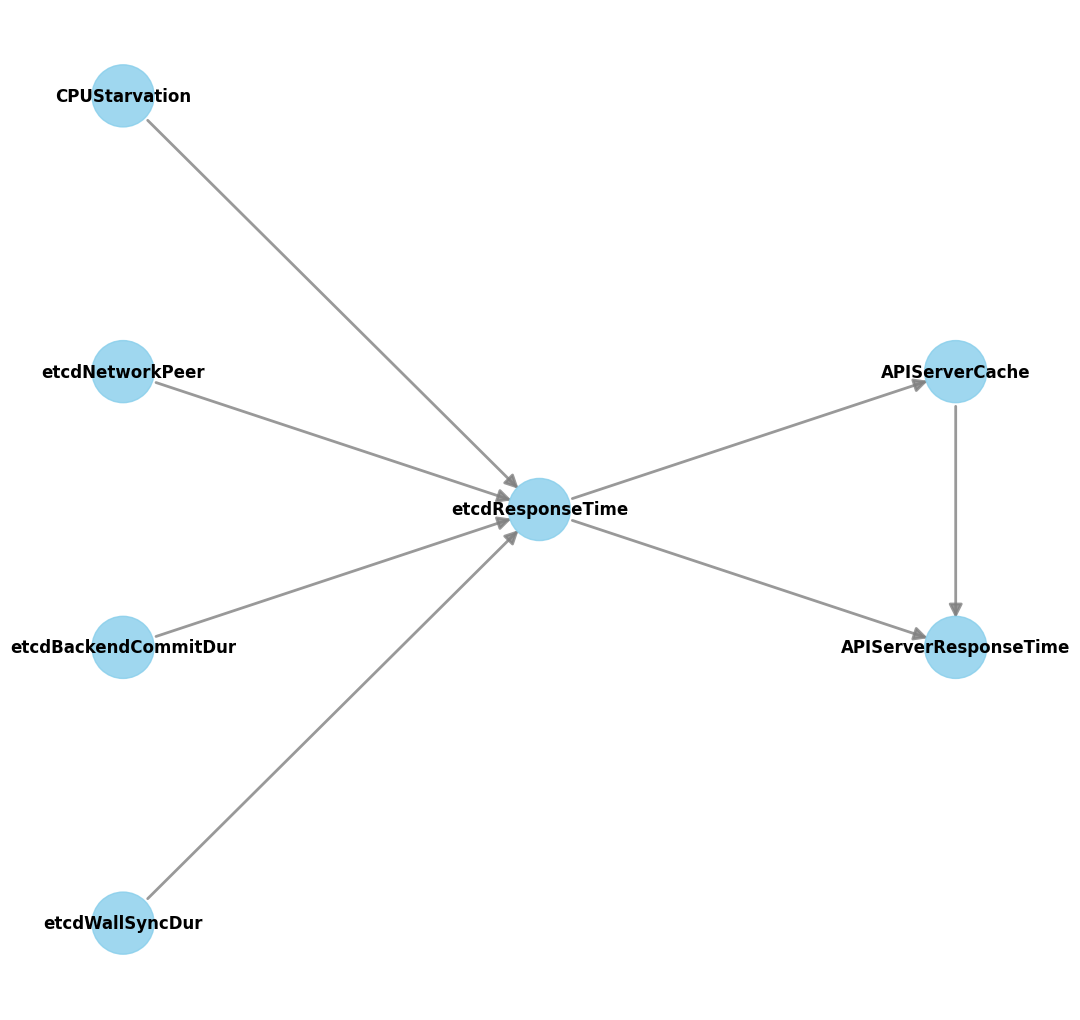

In [8]:
plot(causal_graph_actual, figure_size=[13, 13])

- Here, we are interested in the causal relationships between latencies of services rather than the order of calling the services.

- Do we have any metric about cache response time of API Server? I really hope so because that is a key component in this causal flow. But since I am not aware, I remove it from the `used` graph.

In [9]:
causal_graph_used = nx.DiGraph([('CPUStarvation', 'etcdResponseTime'),
                           ('etcdNetworkPeer', 'etcdResponseTime'),
                           ('etcdBackendCommitDur', 'etcdResponseTime'),
                           ('etcdWallSyncDur', 'etcdResponseTime'),
                           ('etcdResponseTime', 'APIServerResponseTime')
                          ])

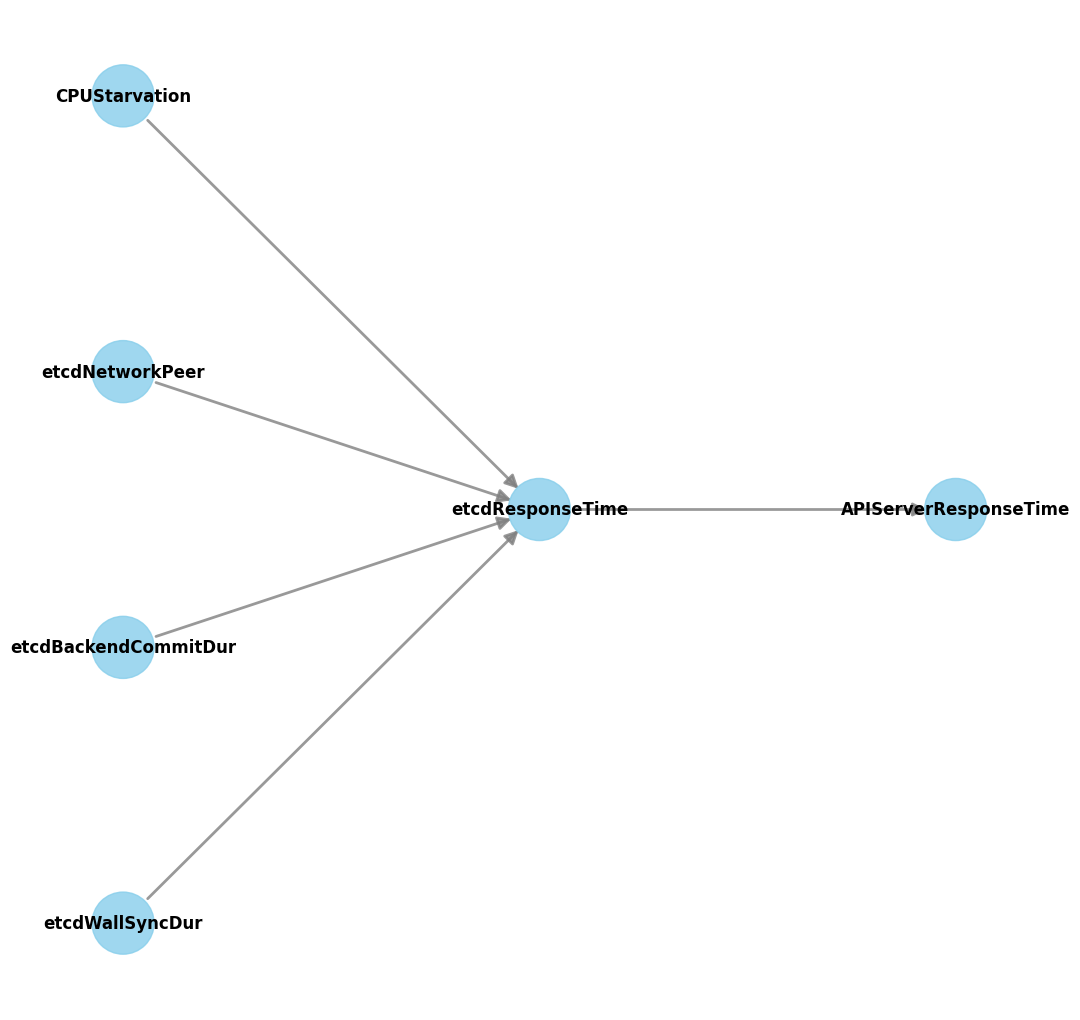

In [10]:
plot(causal_graph_used, figure_size=[13, 13])

In [11]:
def load_file(name) :
    
    fname = os.path.join(name)
    master_df = pd.read_csv(fname,index_col=0)
    return master_df



def prepare_file(raw_df):
    raw_df.rename(columns = {'etcdBackendCommitDuration':'etcdBackendCommitDur'}, inplace = True)
    raw_df.rename(columns = {'etcdWalSyncDuration':'etcdWallSyncDur'}, inplace = True)
    raw_df.rename(columns = {'etcdNetWorkPeerRoundTripDuration':'etcdNetworkPeer'}, inplace = True)
    raw_df.rename(columns = {'etcdDBLeaderElection':'CPUStarvation'}, inplace = True)
    raw_df.rename(columns = {'etcdCPUIOWaitDuration':'etcdResponseTime'}, inplace = True)
    raw_df.rename(columns = {'KubeAPICPUCoreUsage':'APIServerResponseTime'}, inplace = True)
    result_df=raw_df[['CPUStarvation','etcdBackendCommitDur','etcdWallSyncDur','etcdNetworkPeer','etcdResponseTime','APIServerResponseTime']]
    result_df=result_df.reset_index(drop=True)
    return result_df

# This renders histogram in 3 columns per row.
# Fixed format
def examine_skewness_using_histogram(df,colnames):
    #number of rows of display
    #given column =3
    #depends on lenght of colnames
    rowcount=math.ceil(len(colnames)/3)
    
    # Visualizing skewness using histograms and density plots
    fig, axes = plt.subplots(nrows=rowcount, ncols=3, figsize=(10, 7))
    
    i=1
    for x in colnames :
        rowposition = (math.ceil(i/3)) -1
        colposition = i - (rowposition)*3 -1
        sns.histplot(df[x], kde=False, ax=axes[rowposition,colposition])
        axes[rowposition,colposition].set_title(x)    
        i += 1   
    
    plt.tight_layout()
    plt.show()

In [12]:
raw_df=load_file("causal-1.csv")
raw_df

,etcdDBLeaderElection,etcdBackendCommitDuration,etcdWalSyncDuration,etcdNetWorkPeerRoundTripDuration,etcdCPUIOWaitDuration,KubeAPICPUCoreUsage,ACMCPUCoreUsage
timestamp,,,,,,,
1/30/24 21:47,6,0.000994,0.000992,0.012672,0.000595,2.000076,0.518400
1/30/24 21:48,6,0.003392,0.000994,0.012672,0.000595,1.430919,0.390506
1/30/24 21:49,6,0.000990,0.000992,0.012672,0.000595,1.351936,0.391677
1/30/24 21:50,6,0.000994,0.000994,0.012672,0.001190,0.861048,0.328888
1/30/24 21:51,6,0.000990,0.000996,0.012672,0.001190,1.208964,0.384734
...,...,...,...,...,...,...,...
2/2/24 22:52,0,0.000999,0.002204,0.012672,0.001190,1.106441,0.586645
2/2/24 22:53,0,0.003840,0.000999,0.012672,0.002976,1.433999,0.471708
2/2/24 22:54,0,0.000995,0.000992,0.012672,0.001190,1.146951,0.511221


In [13]:
stable_df=prepare_file(raw_df)
stable_df

,CPUStarvation,etcdBackendCommitDur,etcdWallSyncDur,etcdNetworkPeer,etcdResponseTime,APIServerResponseTime
0,6,0.000994,0.000992,0.012672,0.000595,2.000076
1,6,0.003392,0.000994,0.012672,0.000595,1.430919
2,6,0.000990,0.000992,0.012672,0.000595,1.351936
3,6,0.000994,0.000994,0.012672,0.001190,0.861048
4,6,0.000990,0.000996,0.012672,0.001190,1.208964
...,...,...,...,...,...,...
4380,0,0.000999,0.002204,0.012672,0.001190,1.106441
4381,0,0.003840,0.000999,0.012672,0.002976,1.433999
4382,0,0.000995,0.000992,0.012672,0.001190,1.146951
4383,0,0.000995,0.000992,0.012672,0.000595,1.263328


#### Let us draw the treatment and the outcome (or effect) and other metrics in good stable data

array([[<Axes: title={'center': 'CPUStarvation'}>,
        <Axes: title={'center': 'etcdBackendCommitDur'}>,
        <Axes: title={'center': 'etcdWallSyncDur'}>],
       [<Axes: title={'center': 'etcdNetworkPeer'}>,
        <Axes: title={'center': 'etcdResponseTime'}>,
        <Axes: title={'center': 'APIServerResponseTime'}>]], dtype=object)

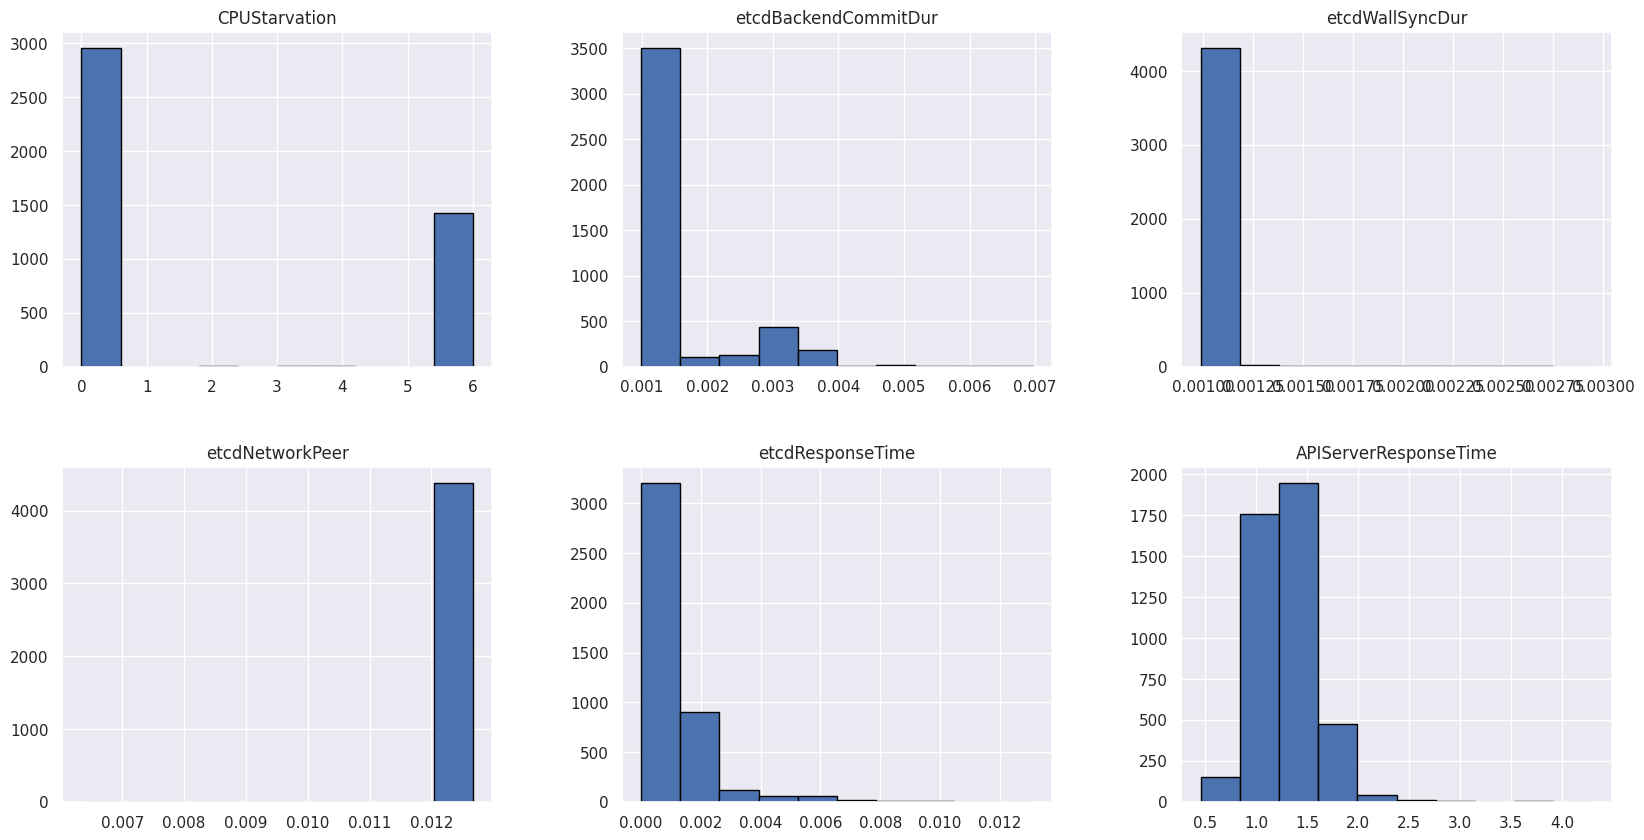

In [14]:
#need to debug what broke - examine_skewness_using_histogram(df,colnames) method
#define format for subplots (1 row and 3 columns)
fig, axis = plt.subplots(2, 3)

#create histogram for each column in DataFrame
#stable_df.hist(ax=axis)
stable_df.hist(ax=axis, edgecolor='black', grid=True)

Text(0.5, 1.0, 'etcdResponseTime')

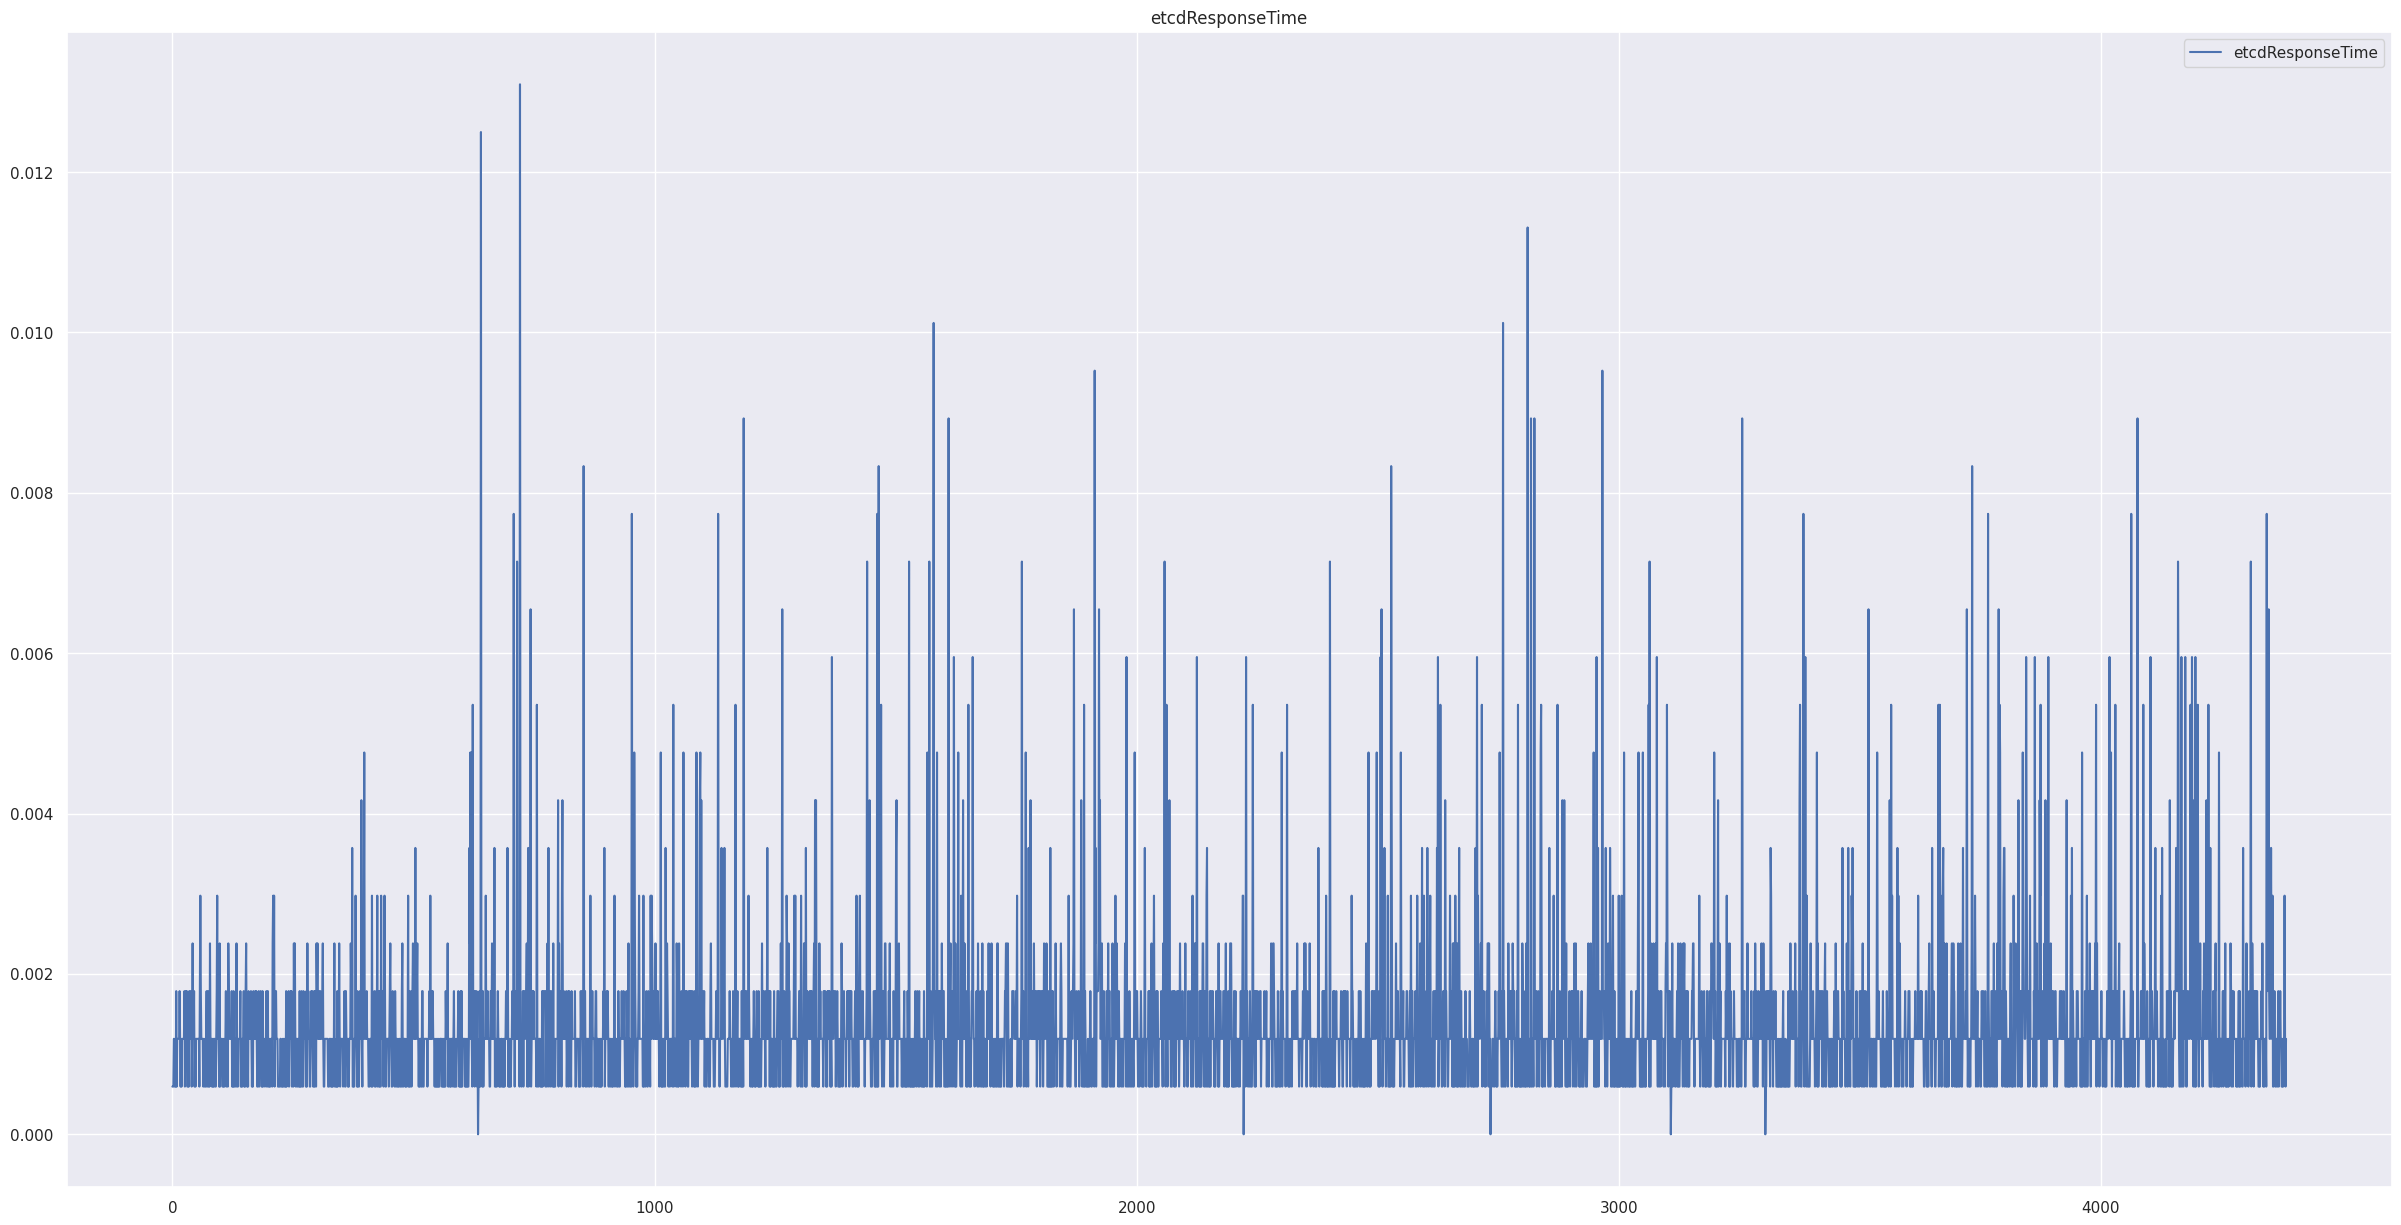

In [16]:
fig, ax = plt.subplots(figsize=(30,15)) 
stable_df.plot(y=["etcdResponseTime"], ax = ax)
plt.title("etcdResponseTime")

Text(0.5, 1.0, 'APIServerResponseTime')

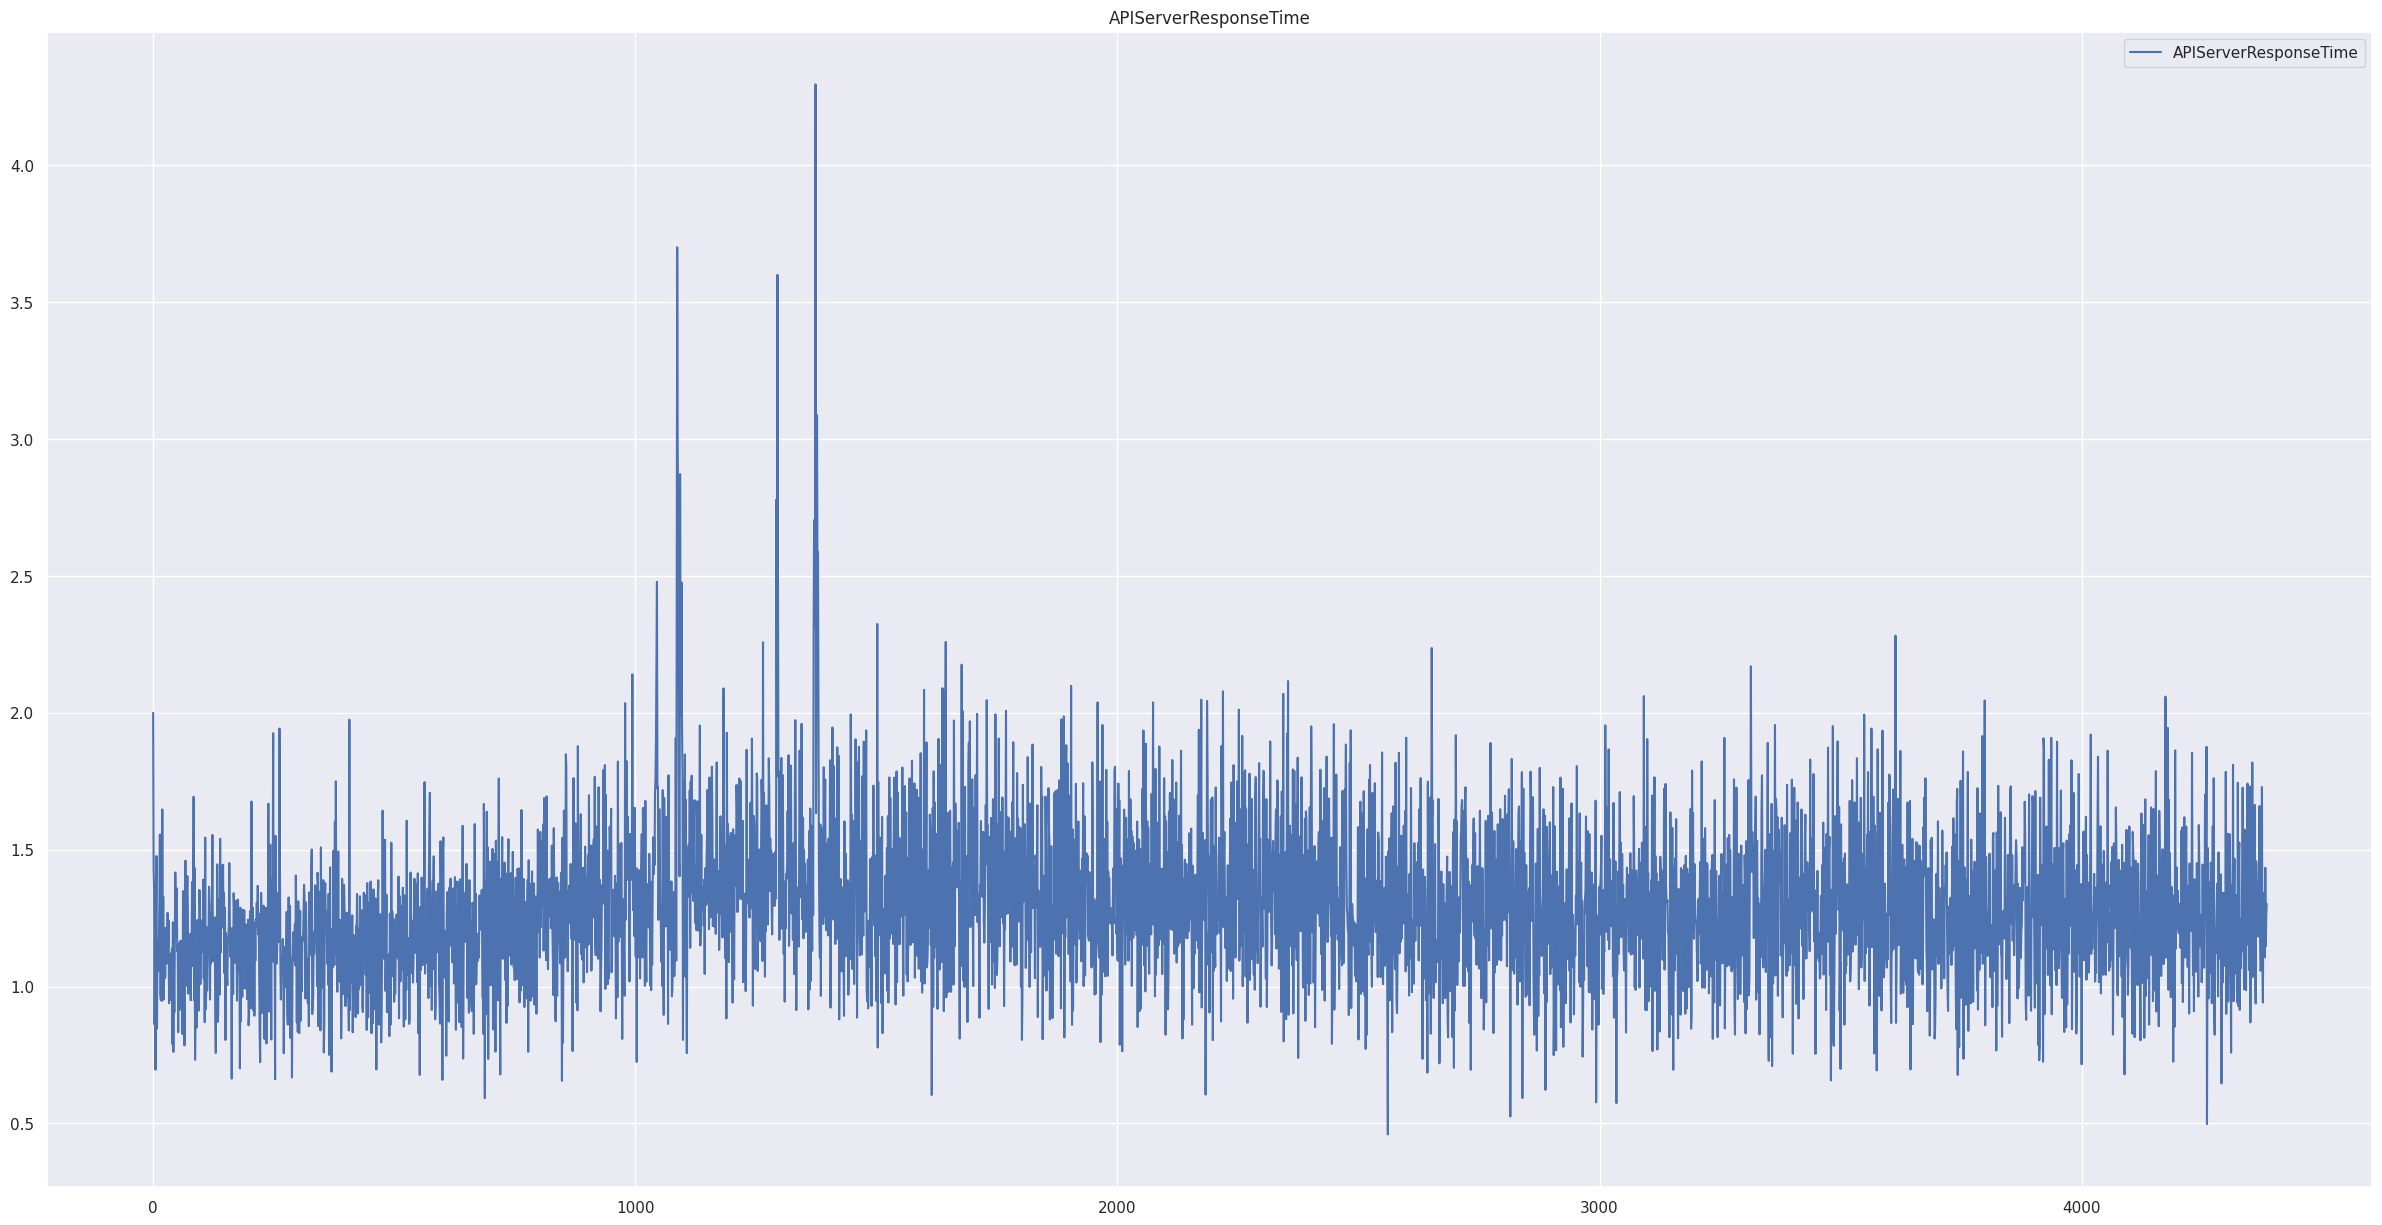

In [17]:
fig, ax = plt.subplots(figsize=(30,15)) 
stable_df.plot(y=["APIServerResponseTime"], ax = ax)
plt.title("APIServerResponseTime")

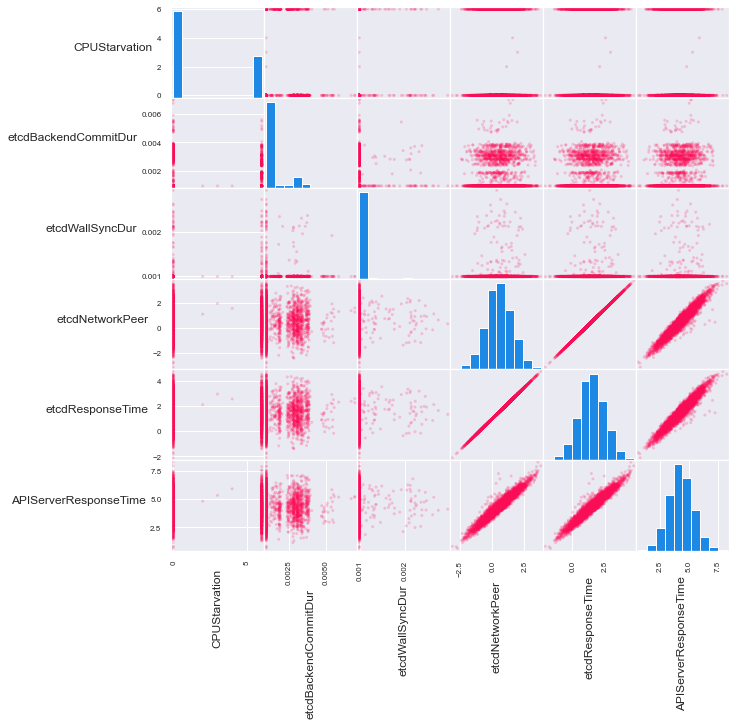

In [18]:
axes = pd.plotting.scatter_matrix(stable_df, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

In [21]:
gcm.auto.assign_causal_mechanisms(scm_model, stable_df)

In [17]:
stable_df.mean()

CPUStarvation            1.947777
etcdBackendCommitDur     0.001410
etcdWallSyncDur          0.001007
etcdNetworkPeer          0.012666
etcdResponseTime         0.001398
APIServerResponseTime    1.292345
dtype: float64

In [18]:
# Calculate current mean
current_mean = stable_df['APIServerResponseTime'].mean()

# New desired mean
new_mean = current_mean + 3

# Calculate adjustment factor
adjustment_factor = new_mean - current_mean

# Define standard deviation for random noise (adjust as needed)
std_dev = 1.0

outlier_df = stable_df
# Add random noise to each value
noise = np.random.normal(loc=0, scale=std_dev, size=len(outlier_df))
outlier_df['APIServerResponseTime'] = outlier_df['APIServerResponseTime'] + adjustment_factor + noise
outlier_df['etcdResponseTime'] = outlier_df['etcdResponseTime'] + 1.5 + noise
outlier_df['etcdNetworkPeer'] = outlier_df['etcdNetworkPeer'] + 0.5 + noise

# Check if the mean is close to the desired mean
outlier_df.mean()

CPUStarvation            1.947777
etcdBackendCommitDur     0.001410
etcdWallSyncDur          0.001007
etcdNetworkPeer          0.526123
etcdResponseTime         1.514855
APIServerResponseTime    4.305801
dtype: float64

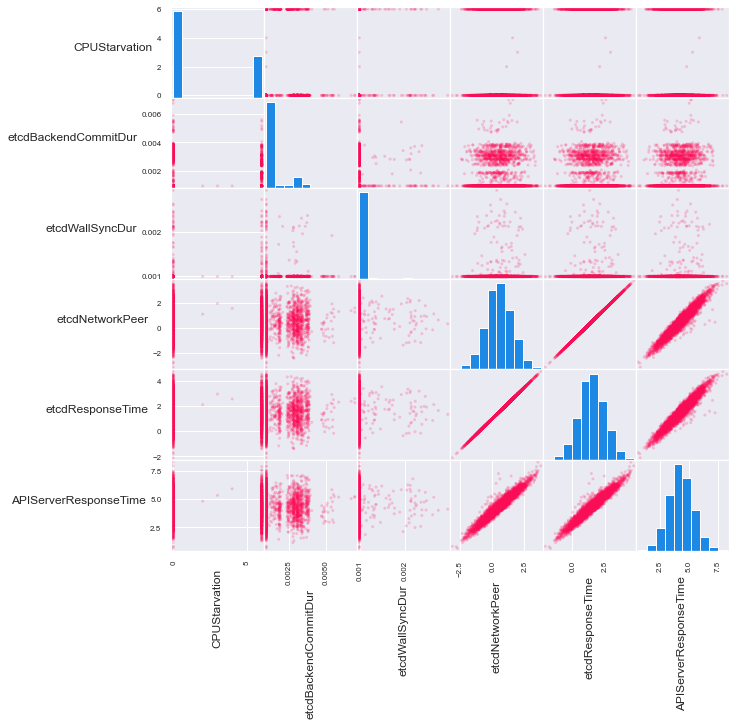

In [25]:
axes = pd.plotting.scatter_matrix(outlier_df, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

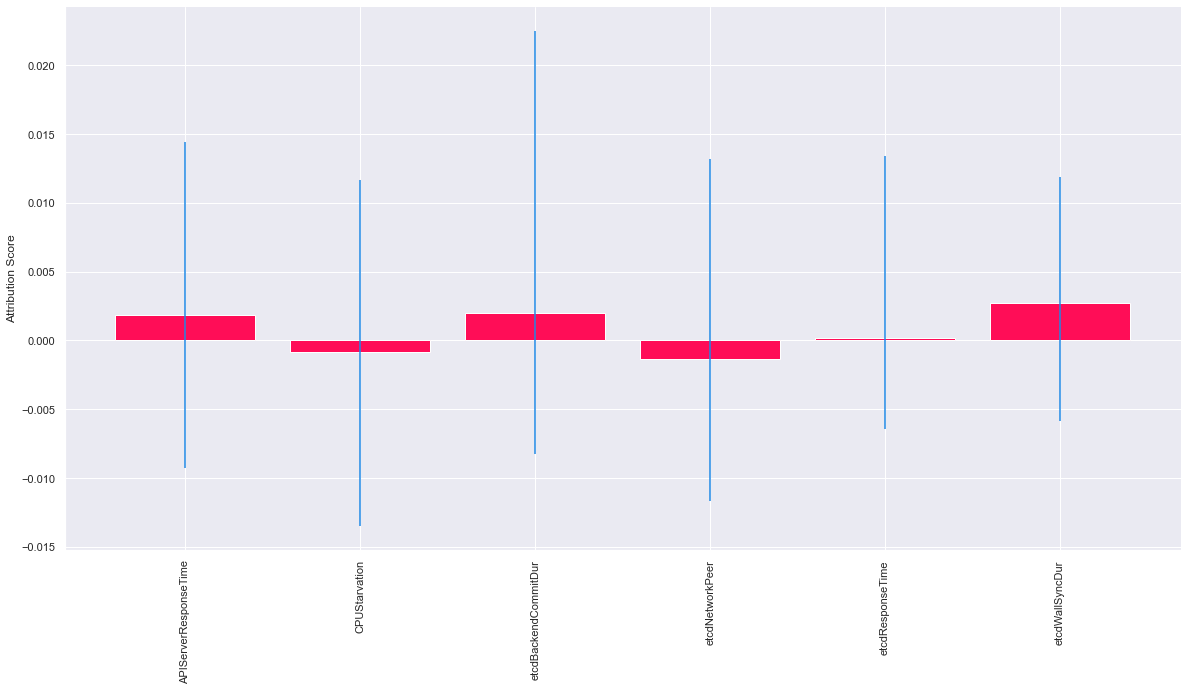

In [19]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values
median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    lambda : gcm.distribution_change(scm_model,
                                     stable_df.sample(frac=0.6),
                                     outlier_df.sample(frac=0.6),
                                     'APIServerResponseTime',
                                     difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x)),
    num_bootstrap_resamples = 10)

bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')

### Build Causal Model

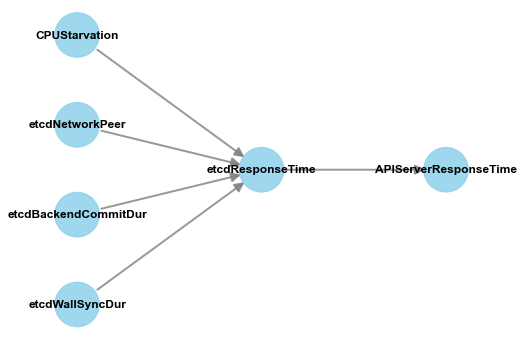

In [20]:
model= CausalModel(
        data=stable_df,
        graph=causal_graph_used,
        treatment="etcdResponseTime",
        outcome="APIServerResponseTime")
model.view_model()

### Identify
Note the parameter flag proceed_when_unidentifiable. It needs to be set to True to convey the assumption that we are ignoring any unobserved confounding. The default behavior is to prompt the user to double-check that the unobserved confounders can be ignored.

In [21]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                   
───────────────────(E[APIServerResponseTime])
d[etcdResponseTime]                          
Estimand assumption 1, Unconfoundedness: If U→{etcdResponseTime} and U→APIServerResponseTime then P(APIServerResponseTime|etcdResponseTime,,U) = P(APIServerResponseTime|etcdResponseTime,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                                   d                                        
E⎢────────────────────────────────────────────────────────────────────────(API
 ⎣d[CPUStarvation  etcdWallSyncDur  etcdBackendCommitDur  etcdNetworkPeer]    

                                                                              
                    ⎛                                   d                     
ServerResponseTime)⋅⎜────────────

### Estimation

In [22]:
help(CausalModel.estimate_effect)

Help on function estimate_effect in module dowhy.causal_model:

estimate_effect(self, identified_estimand, method_name=None, control_value=0, treatment_value=1, test_significance=None, evaluate_effect_strength=False, confidence_intervals=False, target_units='ate', effect_modifiers=None, fit_estimator=True, method_params=None)
    Estimate the identified causal effect.
    
    Currently requires an explicit method name to be specified. Method names follow the convention of identification method followed by the specific estimation method: "[backdoor/iv/frontdoor].estimation_method_name". For a list of supported methods, check out the :doc:`User Guide </user_guide/causal_tasks/estimating_causal_effects/index>`. Here are some examples.
    
        * Propensity Score Matching: "backdoor.propensity_score_matching"
        * Propensity Score Stratification: "backdoor.propensity_score_stratification"
        * Propensity Score-based Inverse Weighting: "backdoor.propensity_score_weighting"
  

In [26]:
#causal_estimate = model.estimate_effect(identified_estimand,
#        method_name="backdoor.propensity_score_stratification")
#print(causal_estimate)